<a href="https://colab.research.google.com/github/ihsrp1/vehicle-image-classifier/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *
from fastai.callback.fp16 import *

In [ ]:
# import shutil
# shutil.rmtree(Path('vehicles'))

## Getting Images

<p>I'll be using the DuckDuckGo Search Engine for gathering images on the different types of vehicles.</p>

In [ ]:
results = search_images_ddg('car', max_images=200)
len(results),results[0]

(298,
 'https://wallup.net/wp-content/uploads/2016/07/21/377429-Audi-car-colorful-Retouch.jpg')

In [ ]:
dest = '/content/images/car.jpg'
download_url(results[0], dest)

Path('/content/images/car.jpg')

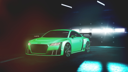

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
vehicle_types = ['motorcycle', 'car', 'truck', 'boat']
path = Path('vehicles')

In [ ]:
if not path.exists():
    path.mkdir()
    for tp in vehicle_types:
        dest = (path/tp)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{tp}', max_images=200)
        download_images(dest, urls=results)

<p>Creating the paths and downloading the files into those paths which will be used as labels for the model.</p>

In [ ]:
fns = get_image_files(path)
fns

(#965) [Path('vehicles/car/00000275.jpg'),Path('vehicles/car/00000110.jpg'),Path('vehicles/car/00000086.jpg'),Path('vehicles/car/00000258.jpg'),Path('vehicles/car/00000048.jpg'),Path('vehicles/car/00000187.jpg'),Path('vehicles/car/00000274.jpg'),Path('vehicles/car/00000038.jpg'),Path('vehicles/car/00000089.jpg'),Path('vehicles/car/00000282.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#2) [Path('vehicles/car/00000181.jpg'),Path('vehicles/motorcycle/00000066.jpg')]

<p>Verifiyng and removing files with problems</p>

In [ ]:
failed.map(Path.unlink);

## From Data to DataLoaders

Here I'll be creating a `DataBlock` with the splitter being the `RandomSplitter` function and using 30% of the data as validation while 70% will be used to train the model.

The `RandomResizedCrop` function will be applied to all items and resize them to 460x460 pixels and using a min_scale of 50%.

And `aug_transforms` will be applied to the batches in order to get a little more variation on the images so that the model can train with different types of brightness and angles.

In [ ]:
vehicles = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(460, min_scale=0.5),
    batch_tfms=aug_transforms(size=224, mult=2))

In [ ]:
dls = vehicles.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


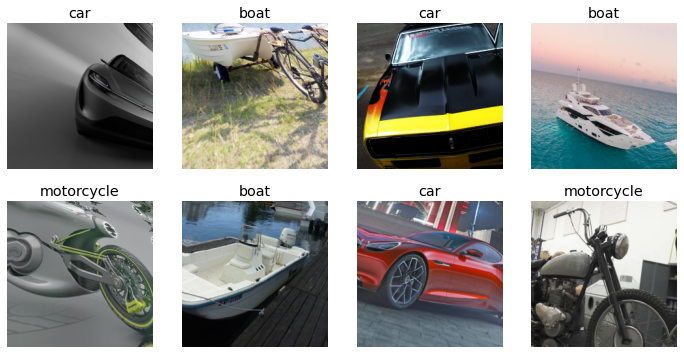

In [ ]:
dls.train.show_batch(max_n=8, nrows=2)

## Training Model

Now for the learner I'll use a `resnet50` (which showed better results compared to `resnet18` and `resnet34`) with the *mixed-precision training* (`to_fp16()` or *half-precision floating point*) in order to speed up the training.

As for the metrics, I decided to go with the most common one (`error_rate`) which will be using the error rate on the training predictions to change the parameters of the neural network.

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
#lr = learn.lr_find()
#lr


Now for the training  4 epochs showed to be suficient while testing and in some cases one of the rates (train, valid or error) would get worse while using more than that.

And also `freeze_epochs` to tell how many epochs to train for while frozen (Freezing basically prevents well-trained weights from being modified). It also automatically change learning rates appropriately for the dataset.

In [ ]:
learn.fine_tune(4, freeze_epochs=2)

epoch,train_loss,valid_loss,error_rate,time
0,1.248844,0.102752,0.034722,00:52
1,0.737608,0.146343,0.041667,00:52


epoch,train_loss,valid_loss,error_rate,time
0,0.227061,0.393994,0.079861,00:53
1,0.190152,0.157727,0.024306,00:53
2,0.191082,0.167314,0.038194,00:53
3,0.160867,0.165925,0.041667,00:53


## Clean Data

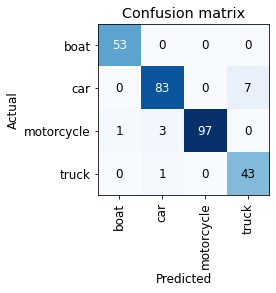

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

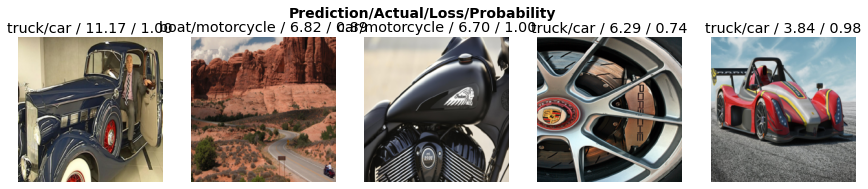

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
# cleaner = ImageClassifierCleaner(learn)
# cleaner

In [ ]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,vehicle in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/vehicle)

## Exporting the model

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

## Using the Model for Inference

### Testing

As a rapid test, the model can use the test image that was downloaded to the 'images/car.jpg' path.

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/car.jpg')

('car', tensor(1), tensor([7.5133e-10, 1.0000e+00, 2.4579e-09, 5.3811e-10]))

And as a result it could predict that it was in fact a car with 100% certainty (the second category of the tensor is 'car').

In [ ]:
learn_inf.dls.vocab

['boat', 'car', 'motorcycle', 'truck']

### Using saved images on the computer

In [ ]:
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your vehicle!'), 
      btn_upload, btn_run, out_pl, lbl_pred])